In [0]:
import os
import pandas as pd
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms, models

from PIL import Image

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from tqdm import tqdm

# 1. Доступность GPU
Определяем на каком типе процессора (CPU или GPU) будем работать

In [0]:
if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


# 2. Воспроизводимость вычислений
Задаем функцию, которая будет устанавливать ransom seed.

Будем запускать эту функцию перед каждым запуском функций, которые полностью или частично инициализируются случайными величинами.

In [0]:
SEED = 42
def set_random_seed_for_everything(seed):
    '''Функция для воспроизводимости вычислений'''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [0]:
!wget -O tiny-imagenet-200.zip http://cs231n.stanford.edu/tiny-imagenet-200.zip

In [0]:
!unzip tiny-imagenet-200.zip

In [0]:
DIR_MAIN = '/content/tiny-imagenet-200/'
DIR_TRAIN = DIR_MAIN + 'train/'
DIR_VAL = DIR_MAIN + 'val/'
DIR_TEST = DIR_MAIN + 'test/'

# 3. Первичная обработка входных и выходных данных
1. Создаем список классов, которые присутствуют в датасете. Создаем encoder для классов.
2. Создаем списки файлов и соответствующие списки классов

In [0]:
# Количество классов - 200
labels = os.listdir(DIR_TRAIN)

# Создаем энкодер классов
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Список файлов для тренировки модели (размер: 100'000)
files_train = []
for label in labels:
    for filename in os.listdir(DIR_TRAIN + label + '/images/'):
        files_train.append(DIR_TRAIN + label + '/images/' + filename)
files_train = sorted(files_train)

# Список классов для тренировки модели (размер: 100'000)
labels_train = []
for f in files_train:
    labels_train.append(f[len(DIR_TRAIN) : len(DIR_TRAIN) + len(labels[0])])

# Список файлов для валидации модели (размер: 10'000)
files_val = []
for filename in os.listdir(DIR_VAL + 'images/'):
    files_val.append(DIR_VAL + 'images/' + filename)
files_val = sorted(files_val)

# Cписок классов для валидации модели (размер: 10'000)
labels_val = []
val_df = pd.read_csv(DIR_VAL + 'val_annotations.txt', sep='\t', names=["File", "Label", "X1", "Y1", "X2", "Y2"], usecols=["File", "Label"])
for f in files_val:
    l = val_df.loc[val_df['File'] == f[len(DIR_VAL + 'images/'):]]['Label'].values[0]
    labels_val.append(l)

# Список файлов для тестирования модели (размер: 10'000)
files_test = []
for filename in os.listdir(DIR_TEST + 'images/'):
    files_test.append(DIR_TEST + 'images/' + filename)
files_test = sorted(files_test)

# 4. Класс для создания датасета

In [0]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transform_train, transform_val, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transform_train = transform_train
        self.transform_val = transform_val
        if mode not in ['train', 'val', 'test']:
            print("'{}' mode is not correct. Correct modes: 'train', 'val', 'test'".format(mode))
            raise NameError
        else:
            self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train':
            x = self.transform_train(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'val':
            x = transform_val(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = transform_val(pic)
            return x, self.files[index]

# 5. Функции для инициализации (модели, оптимизатора, трансформаций):
- Модели: используем предобученные модели, доступные в torchvision, переобучая только последний полносвязный слой.
- Оптимизатора: используем Adam, изменяем lr.
- Трансформаций: изменяем праметры для transforms.RandomErasing и transforms.ColorJitter.


In [0]:
def model_initialization(model_name):
    if model_name not in ['ResNet152', 'VGG19bn', 'Densenet161']:
        print("'{}' model name is not correct. Correct model names: 'ResNet152', 'VGG19bn', 'Densenet161'".format(model_name))
        raise NameError
    else:
        set_random_seed_for_everything(SEED)
        if model_name == 'ResNet152':
            model = models.resnet152(pretrained=True)
            for param in model.parameters():
                param.requires_grad = False
            model.fc = torch.nn.Linear(model.fc.in_features, 200)
            model = model.to(DEVICE)
        elif model_name == 'VGG19bn':
            model = models.vgg19_bn(pretrained = True)
            for param in model.parameters():
                param.requires_grad = False
            for param in model.classifier.parameters():
                param.requires_grad = True
            model.classifier[6] = torch.nn.Linear(in_features=model.classifier[6].in_features, out_features=200)
            model = model.to(DEVICE)
        elif model_name == 'Densenet161':
            model = models.densenet161(pretrained=True)
            for param in model.parameters():
                param.requires_grad = False
            model.classifier = torch.nn.Linear(model.classifier.in_features, out_features=200)
            model = model.to(DEVICE)
        return model

def optimizer_initialization(model, learning_rate):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return optimizer

def transform_train_initialization(col_jit_param, rand_eras_scale):
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=col_jit_param[0], contrast=col_jit_param[1], saturation=col_jit_param[2], hue=col_jit_param[3]),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        transforms.RandomErasing(p=0.5, scale=(rand_eras_scale, rand_eras_scale), ratio=(1, 3), value=0, inplace=True)
    ])
    return transform_train

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

### Просмотр случайных картинок из тренировочного датасета
Проверяем как работают аугментации, которые мы планируем применять

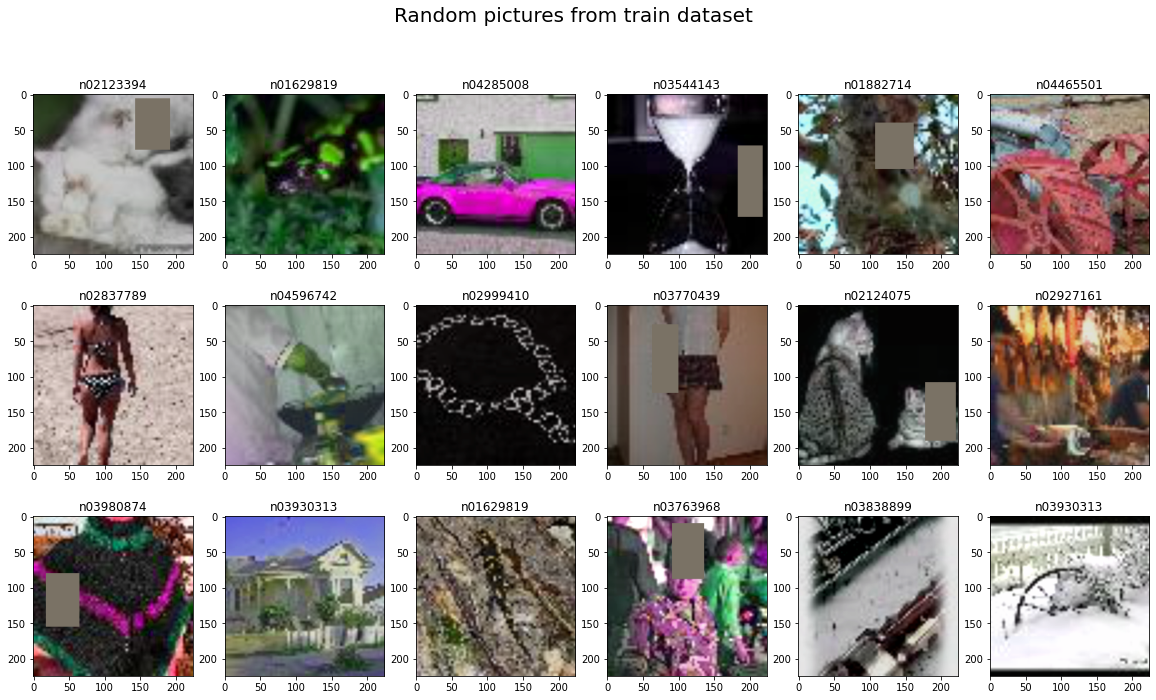

In [0]:
transform_train = transform_train_initialization((0.2, 0.2, 0.2, 0.2), 0.07)
train_dataset = ImagesDataset(files_train, labels_train, encoder_labels, transform_train, transform_val, 'train')

fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Random pictures from train dataset', fontsize=20)
set_random_seed_for_everything(SEED)
for ax in axs.flatten():
    n = np.random.randint(len(train_dataset))
    img = train_dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([train_dataset[n][1]])[0])
    ax.imshow(img)  

# 6. Функция для обучения моделей
В процессе обучения сохраняем в файл веса модели, при которых модель показывает наименьший loss на валидационном датасете.

Если после очередной эпохи обучения val_loss оказывается меньше, чем текущий минимальный, то перезаписываем файл с весами.

При таком подходе у нас останется файл с наилучшими весами модели в том случае, если модель начнет переобучаться, и с увеличением эпохи val_loss начнет возрастать

In [0]:
def training(model, model_name, lowest_val_loss, num_epochs, train_dataloader, val_dataloader, optimizer):

    loss_function = torch.nn.CrossEntropyLoss()
    
    # Уменьшаем learning rate в 3 раза каждые 3 эпохи
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []

    for epoch in range(num_epochs):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            running_loss = 0
            running_acc = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        acc = (preds == targets).float().mean()
                        loss.backward()
                        optimizer.step()

                        running_loss += loss.item()
                        running_acc += acc.item()

                train_loss_array.append(running_loss / len(train_dataloader))
                train_acc_array.append(running_acc / len(train_dataloader))

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        acc = (preds == targets).float().mean()

                        running_loss += loss.item()
                        running_acc += acc.item()

                val_loss_array.append(running_loss / len(val_dataloader))
                val_acc_array.append(running_acc / len(val_dataloader))

                if running_loss / len(val_dataloader) < lowest_val_loss:
                    lowest_val_loss = running_loss / len(val_dataloader)
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

    return train_loss_array, train_acc_array, val_loss_array, val_acc_array, lowest_val_loss

# 7. Цикл обучения моделей

Берем предобученные ResNet152, Densenet161, VGG19bn.

Переобучаем модели при различных наборах гиперпараметров, сгенерированных ранее.

Определяем гиперпараметры, при которых достигнута наименьшая ошибка на валидации.

Веса моделей, при которых достигнута наименьшая ошибка на валидации, будут использоваться в дальнейшем для обучения ансамбля моделей.

## 7.1.a Обучаем DenseNet161

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth



Epoch: 1 | Learning rate: [0.001]
	| New lowest val loss for Densenet161: 1.5178638464212417
Epoch: 2 | Learning rate: [0.001]
	| New lowest val loss for Densenet161: 1.4175406062602998
Epoch: 3 | Learning rate: [0.001]
	| New lowest val loss for Densenet161: 1.374577013850212
Epoch: 4 | Learning rate: [0.0001089]
	| New lowest val loss for Densenet161: 1.2992479786276818
Epoch: 5 | Learning rate: [0.00033]
	| New lowest val loss for Densenet161: 1.2972324758768081
Epoch: 6 | Learning rate: [0.00033]
	| New lowest val loss for Densenet161: 1.288106770813465
Epoch: 7 | Learning rate: [3.5937000000000005e-05]
	| New lowest val loss for Densenet161: 1.2697855040431023
Epoch: 8 | Learning rate: [0.0001089]
	| New lowest val loss for Densenet161: 1.2645643210411073
Epoch: 9 | Learning rate: [0.0001089]
	| New lowest val loss for Densenet161: 1.2591540658473968
Epoch: 10 | Learning rate: [1.1859210000000002e-05]
Epoch: 11 | Learning rate: [3.5937000000000005e-05]
Epoch: 12 | Learning rate: 

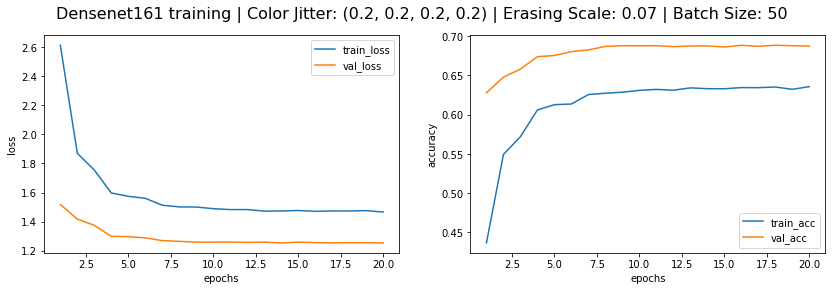


Training results:

Model Densenet161:
Set of hyperparameters #1:
	Batch size: 50 | Color jitter parameters: (brightness, contrast, saturation, hue): (0.2, 0.2, 0.2, 0.2) | Random erasing scale: 0.07
	Min val loss 1.2538 was achieved during iteration #14
	Val accuracy during min val loss is 0.6876


In [14]:
num_epochs = 20

# Словарь, в который будем сохранять историю историю loss и accuracy при обучении моделей
models_training_history = {'Densenet161': []}
models_lowest_val_loss = {'Densenet161': 10000}

# Цикл по моделям
for model_name, _ in models_training_history.items():

    # Инициализируем модель, оптимайзер и трансформации
    model = model_initialization(model_name)
    optimizer = optimizer_initialization(model, 0.001)
    transform_train = transform_train_initialization((0.2, 0.2, 0.2, 0.2), 0.07)

    # Создаем датасеты
    train_dataset = ImagesDataset(files_train, labels_train, encoder_labels, transform_train, transform_val, 'train')
    val_dataset = ImagesDataset(files_val, labels_val, encoder_labels, transform_train, transform_val, 'val')

    # Создаем даталоадеры
    set_random_seed_for_everything(SEED)
    train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

    # Тренируем модель и сохраняем результат
    train_loss_array, train_acc_array, val_loss_array, val_acc_array, new_lowest_val_loss = training(model, model_name, models_lowest_val_loss[model_name], num_epochs, train_dataloader, val_dataloader, optimizer)
    models_lowest_val_loss[model_name] = new_lowest_val_loss
    models_training_history[model_name].append([train_loss_array, train_acc_array, val_loss_array, val_acc_array])

    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Color Jitter: {} | Erasing Scale: {} | Batch Size: {}".format(model_name, (0.2, 0.2, 0.2, 0.2), 0.07, 50), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

print("\nTraining results:")
for key, value in models_training_history.items():
    print("\nModel {}:".format(key))
    for i in range(len(value)):
        print("Set of hyperparameters #{}:".format(i + 1))
        print("\tBatch size: {} | Color jitter parameters: (brightness, contrast, saturation, hue): {} | Random erasing scale: {}".format(50, (0.2, 0.2, 0.2, 0.2), 0.07))
        print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min(value[i][2]), value[i][2].index(min(value[i][2])) + 1))
        print("\tVal accuracy during min val loss is {:.4f}".format(value[i][3][value[i][2].index(min(value[i][2]))]))

## 7.1.b Тестируем модель Densenet161 на валидационном датасете

100%|██████████| 200/200 [01:28<00:00,  2.25it/s]


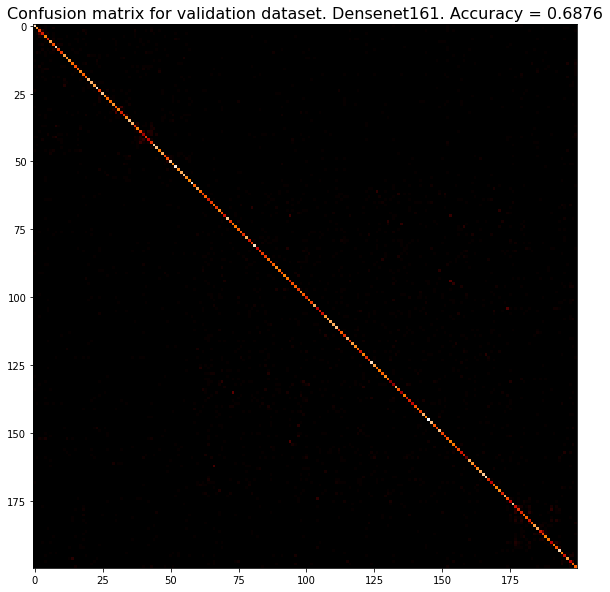

In [15]:
# Загружаем веса для модели Densenet161, которые дают наименьший loss на валидационном датасете
model_densenet161 = models.densenet161(pretrained = False)
model_densenet161.classifier = torch.nn.Linear(in_features=2208, out_features=200)
model_densenet161.load_state_dict(torch.load('Densenet161_weights.pth'))
model_densenet161 = model_densenet161.to(DEVICE)

# Строим confusion matrix для валидационного датасета
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

all_preds = []
all_targets = []

model_densenet161.eval()
with torch.no_grad():
    for samples, targets in tqdm(val_dataloader):
        samples = samples.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = model_densenet161(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_targets.extend(targets.tolist())

accuracy = np.array(all_preds) == np.array(all_targets)

# Рассчитываем confusion matrix
confusion_matrix = [[0 for i in range(200)] for i in range(200)]
for i in range(len(all_targets)):
    confusion_matrix[all_targets[i]][all_preds[i]] += 1

# Отрисовываем confusion matrix
plt.figure(figsize=(10, 10))
plt.title('Confusion matrix for validation dataset. Densenet161. Accuracy = {}'.format(accuracy.mean()), fontsize=16)
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
plt.show()

## 7.1.c Классифицируем тестовый датасет с помощью модели Densenet161

In [16]:
test_dataset = ImagesDataset(files_test, None, None, None, transform_val, 'test')
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

all_preds = []
all_files = []

model_densenet161.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        samples = samples.to(DEVICE)
        outputs = model_densenet161(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames = [f_name[39:] for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

submission_densenet161_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_densenet161_df.to_csv('test_predictions_densenet161.csv', header=False, index=False) 
submission_densenet161_df.head(10)

100%|██████████| 200/200 [01:27<00:00,  2.28it/s]


,File,Prediction
0,test_0.JPEG,n02948072
1,test_1.JPEG,n07583066
2,test_10.JPEG,n07583066
3,test_100.JPEG,n04376876
4,test_1000.JPEG,n02099601
5,test_1001.JPEG,n03617480
6,test_1002.JPEG,n03637318
7,test_1003.JPEG,n07695742
8,test_1004.JPEG,n04356056
9,test_1005.JPEG,n03388043


## 7.2.a Обучаем ResNet152

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth



Epoch: 1 | Learning rate: [0.001]
	| New lowest val loss for ResNet152: 1.70176042675972
Epoch: 2 | Learning rate: [0.001]
	| New lowest val loss for ResNet152: 1.634644352197647
Epoch: 3 | Learning rate: [0.001]
Epoch: 4 | Learning rate: [0.0001089]
	| New lowest val loss for ResNet152: 1.4274773070216178
Epoch: 5 | Learning rate: [0.00033]
Epoch: 6 | Learning rate: [0.00033]
	| New lowest val loss for ResNet152: 1.403839292228222
Epoch: 7 | Learning rate: [3.5937000000000005e-05]
	| New lowest val loss for ResNet152: 1.3682767644524574
Epoch: 8 | Learning rate: [0.0001089]
	| New lowest val loss for ResNet152: 1.3641092175245284
Epoch: 9 | Learning rate: [0.0001089]
	| New lowest val loss for ResNet152: 1.3541662919521331
Epoch: 10 | Learning rate: [1.1859210000000002e-05]
	| New lowest val loss for ResNet152: 1.340856859087944


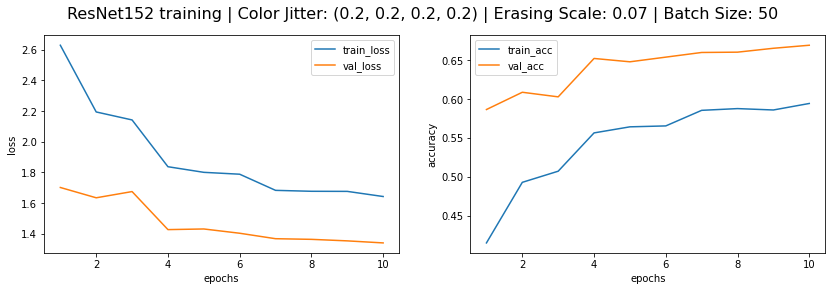


Training results:

Model ResNet152:
Set of hyperparameters #1:
	Batch size: 50 | Color jitter parameters: (brightness, contrast, saturation, hue): (0.2, 0.2, 0.2, 0.2) | Random erasing scale: 0.07
	Min val loss 1.3409 was achieved during iteration #10
	Val accuracy during min val loss is 0.6691


In [0]:
num_epochs = 10

# Словарь, в который будем сохранять историю историю loss и accuracy при обучении моделей
models_training_history = {'ResNet152': []}
models_lowest_val_loss = {'ResNet152': 10000}

# Цикл по моделям
for model_name, _ in models_training_history.items():

    # Инициализируем модель, оптимайзер и трансформации
    model = model_initialization(model_name)
    optimizer = optimizer_initialization(model, 0.001)
    transform_train = transform_train_initialization((0.2, 0.2, 0.2, 0.2), 0.07)

    # Создаем датасеты
    train_dataset = ImagesDataset(files_train, labels_train, encoder_labels, transform_train, transform_val, 'train')
    val_dataset = ImagesDataset(files_val, labels_val, encoder_labels, transform_train, transform_val, 'val')

    # Создаем даталоадеры
    set_random_seed_for_everything(SEED)
    train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

    # Тренируем модель и сохраняем результат
    train_loss_array, train_acc_array, val_loss_array, val_acc_array, new_lowest_val_loss = training(model, model_name, models_lowest_val_loss[model_name], num_epochs, train_dataloader, val_dataloader, optimizer)
    models_lowest_val_loss[model_name] = new_lowest_val_loss
    models_training_history[model_name].append([train_loss_array, train_acc_array, val_loss_array, val_acc_array])

    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Color Jitter: {} | Erasing Scale: {} | Batch Size: {}".format(model_name, (0.2, 0.2, 0.2, 0.2), 0.07, 50), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

print("\nTraining results:")
for key, value in models_training_history.items():
    print("\nModel {}:".format(key))
    for i in range(len(value)):
        print("Set of hyperparameters #{}:".format(i + 1))
        print("\tBatch size: {} | Color jitter parameters: (brightness, contrast, saturation, hue): {} | Random erasing scale: {}".format(50, (0.2, 0.2, 0.2, 0.2), 0.07))
        print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min(value[i][2]), value[i][2].index(min(value[i][2])) + 1))
        print("\tVal accuracy during min val loss is {:.4f}".format(value[i][3][value[i][2].index(min(value[i][2]))]))

## 7.2.b Тестируем модель ResNet152 на валидационном датасете

100%|██████████| 200/200 [01:06<00:00,  3.00it/s]


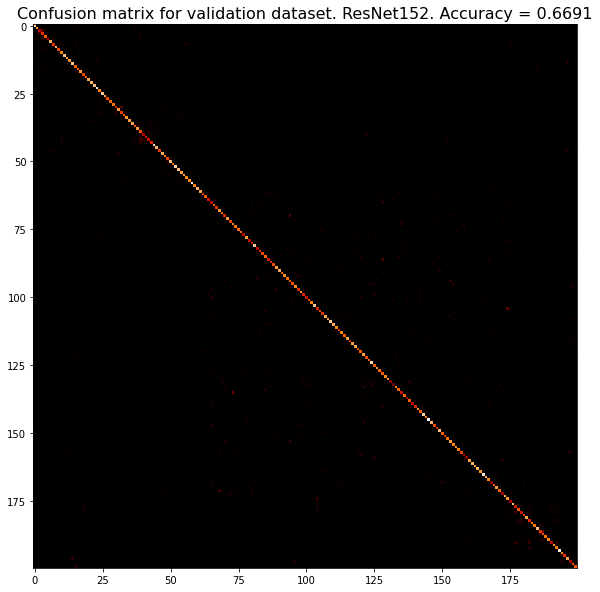

In [0]:
# Загружаем веса для модели ResNet152, которые дают наименьший loss на валидационном датасете
model_resnet152 = models.resnet152(pretrained = False)
model_resnet152.fc = torch.nn.Linear(in_features=2048, out_features=200)
model_resnet152.load_state_dict(torch.load('ResNet152_weights.pth'))
model_resnet152 = model_resnet152.to(DEVICE)

# Строим confusion matrix для валидационного датасета
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

all_preds = []
all_targets = []

model_resnet152.eval()
with torch.no_grad():
    for samples, targets in tqdm(val_dataloader):
        samples = samples.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = model_resnet152(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_targets.extend(targets.tolist())

accuracy = np.array(all_preds) == np.array(all_targets)

# Рассчитываем confusion matrix
confusion_matrix = [[0 for i in range(200)] for i in range(200)]
for i in range(len(all_targets)):
    confusion_matrix[all_targets[i]][all_preds[i]] += 1

# Отрисовываем confusion matrix
plt.figure(figsize=(10, 10))
plt.title('Confusion matrix for validation dataset. ResNet152. Accuracy = {}'.format(accuracy.mean()), fontsize=16)
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
plt.show()

## 7.2.c Классифицируем тестовый датасет с помощью модели ResNet152

In [0]:
test_dataset = ImagesDataset(files_test, None, None, None, transform_val, 'test')
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

all_preds = []
all_files = []

model_resnet152.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        samples = samples.to(DEVICE)
        outputs = model_resnet152(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames = [f_name[39:] for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

submission_resnet152_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_resnet152_df.to_csv('test_predictions_resnet152.csv', header=False, index=False) 
submission_resnet152_df.head(10)

100%|██████████| 200/200 [01:05<00:00,  3.06it/s]


,File,Prediction
0,test_0.JPEG,n04023962
1,test_1.JPEG,n07871810
2,test_10.JPEG,n07583066
3,test_100.JPEG,n04376876
4,test_1000.JPEG,n02099601
5,test_1001.JPEG,n03617480
6,test_1002.JPEG,n03637318
7,test_1003.JPEG,n01774750
8,test_1004.JPEG,n03404251
9,test_1005.JPEG,n03388043


## 7.3.a Обучаем VGG19bn

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth



Epoch: 1 | Learning rate: [0.001]
	| New lowest val loss for VGG19bn: 3.41758296251297
Epoch: 2 | Learning rate: [0.001]
	| New lowest val loss for VGG19bn: 3.2097702622413635
Epoch: 3 | Learning rate: [0.001]
	| New lowest val loss for VGG19bn: 3.091435203552246
Epoch: 4 | Learning rate: [0.0001089]
	| New lowest val loss for VGG19bn: 2.7844248497486115
Epoch: 5 | Learning rate: [0.00033]
	| New lowest val loss for VGG19bn: 2.722341387271881
Epoch: 6 | Learning rate: [0.00033]
	| New lowest val loss for VGG19bn: 2.6660138165950773
Epoch: 7 | Learning rate: [3.5937000000000005e-05]
	| New lowest val loss for VGG19bn: 2.5746375644207
Epoch: 8 | Learning rate: [0.0001089]
	| New lowest val loss for VGG19bn: 2.538654475212097
Epoch: 9 | Learning rate: [0.0001089]
	| New lowest val loss for VGG19bn: 2.4945147681236266
Epoch: 10 | Learning rate: [1.1859210000000002e-05]
	| New lowest val loss for VGG19bn: 2.476778584718704


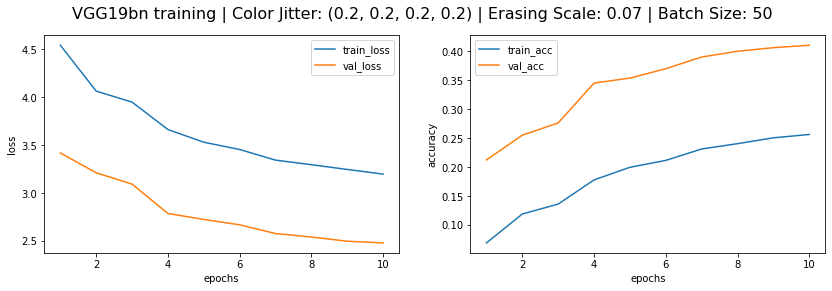


Training results:

Model VGG19bn:
Set of hyperparameters #1:
	Batch size: 50 | Color jitter parameters: (brightness, contrast, saturation, hue): (0.2, 0.2, 0.2, 0.2) | Random erasing scale: 0.07
	Min val loss 2.4768 was achieved during iteration #10
	Val accuracy during min val loss is 0.4100


In [0]:
num_epochs = 10

# Словарь, в который будем сохранять историю историю loss и accuracy при обучении моделей
models_training_history = {'VGG19bn': []}
models_lowest_val_loss = {'VGG19bn': 10000}

# Цикл по моделям
for model_name, _ in models_training_history.items():

    # Инициализируем модель, оптимайзер и трансформации
    model = model_initialization(model_name)
    optimizer = optimizer_initialization(model, 0.001)
    transform_train = transform_train_initialization((0.2, 0.2, 0.2, 0.2), 0.07)

    # Создаем датасеты
    train_dataset = ImagesDataset(files_train, labels_train, encoder_labels, transform_train, transform_val, 'train')
    val_dataset = ImagesDataset(files_val, labels_val, encoder_labels, transform_train, transform_val, 'val')

    # Создаем даталоадеры
    set_random_seed_for_everything(SEED)
    train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

    # Тренируем модель и сохраняем результат
    train_loss_array, train_acc_array, val_loss_array, val_acc_array, new_lowest_val_loss = training(model, model_name, models_lowest_val_loss[model_name], num_epochs, train_dataloader, val_dataloader, optimizer)
    models_lowest_val_loss[model_name] = new_lowest_val_loss
    models_training_history[model_name].append([train_loss_array, train_acc_array, val_loss_array, val_acc_array])

    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Color Jitter: {} | Erasing Scale: {} | Batch Size: {}".format(model_name, (0.2, 0.2, 0.2, 0.2), 0.07, 50), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

print("\nTraining results:")
for key, value in models_training_history.items():
    print("\nModel {}:".format(key))
    for i in range(len(value)):
        print("Set of hyperparameters #{}:".format(i + 1))
        print("\tBatch size: {} | Color jitter parameters: (brightness, contrast, saturation, hue): {} | Random erasing scale: {}".format(50, (0.2, 0.2, 0.2, 0.2), 0.07))
        print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min(value[i][2]), value[i][2].index(min(value[i][2])) + 1))
        print("\tVal accuracy during min val loss is {:.4f}".format(value[i][3][value[i][2].index(min(value[i][2]))]))

## 7.3.b Тестируем модель VGG19bn на валидационном датасете

100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


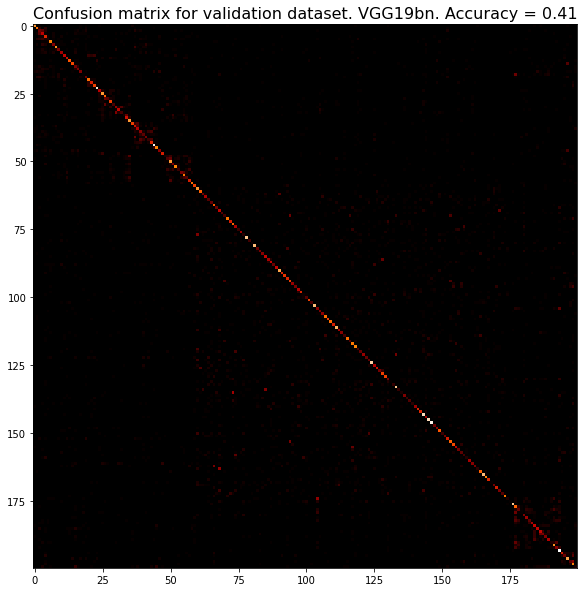

In [0]:
# Загружаем веса для модели VGG19bn, которые дают наименьший loss на валидационном датасете
model_vgg19bn = models.vgg19_bn(pretrained = False)
model_vgg19bn.classifier[6] = torch.nn.Linear(in_features=4096, out_features=200)
model_vgg19bn.load_state_dict(torch.load('VGG19bn_weights.pth'))
model_vgg19bn = model_vgg19bn.to(DEVICE)

# Строим confusion matrix для валидационного датасета
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

all_preds = []
all_targets = []

model_vgg19bn.eval()
with torch.no_grad():
    for samples, targets in tqdm(val_dataloader):
        samples = samples.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = model_vgg19bn(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_targets.extend(targets.tolist())

accuracy = np.array(all_preds) == np.array(all_targets)

# Рассчитываем confusion matrix
confusion_matrix = [[0 for i in range(200)] for i in range(200)]
for i in range(len(all_targets)):
    confusion_matrix[all_targets[i]][all_preds[i]] += 1

# Отрисовываем confusion matrix
plt.figure(figsize=(10, 10))
plt.title('Confusion matrix for validation dataset. VGG19bn. Accuracy = {}'.format(accuracy.mean()), fontsize=16)
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
plt.show()

## 7.3.c Классифицируем тестовый датасет с помощью модели VGG19bn

In [0]:
test_dataset = ImagesDataset(files_test, None, None, None, transform_val, 'test')
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

all_preds = []
all_files = []

model_vgg19bn.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        samples = samples.to(DEVICE)
        outputs = model_vgg19bn(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames = [f_name[39:] for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

submission_vgg19bn_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_vgg19bn_df.to_csv('test_predictions_vgg19bn.csv', header=False, index=False) 
submission_vgg19bn_df.head(10)

100%|██████████| 200/200 [02:07<00:00,  1.57it/s]


,File,Prediction
0,test_0.JPEG,n02823428
1,test_1.JPEG,n07579787
2,test_10.JPEG,n07583066
3,test_100.JPEG,n03976657
4,test_1000.JPEG,n02099601
5,test_1001.JPEG,n03026506
6,test_1002.JPEG,n07720875
7,test_1003.JPEG,n01742172
8,test_1004.JPEG,n02669723
9,test_1005.JPEG,n04366367


# 8. Ансамбль из переобученных моделей
Все модели собираем в одну, на последнем слое получается 600 выходов (3 по 200 с каждой модели). При помощи полносвязного слоя преобразуем их в 200 выходов.

Обучаем слой-классификатор 

In [0]:
# Ансамбль из нескольких моделей
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(200 * 3, 200)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out
    
model_vgg19bn = models.vgg19_bn(pretrained = False)
model_vgg19bn.classifier[6] = torch.nn.Linear(in_features=4096, out_features=200)

model_resnet152 = models.resnet152(pretrained = False)
model_resnet152.fc = torch.nn.Linear(in_features=2048, out_features=200)

model_densenet161 = models.densenet161(pretrained = False)
model_densenet161.classifier = torch.nn.Linear(in_features=2208, out_features=200)

model_vgg19bn.load_state_dict(torch.load('VGG19bn_weights.pth'))
model_resnet152.load_state_dict(torch.load('ResNet152_weights.pth'))
model_densenet161.load_state_dict(torch.load('Densenet161_weights.pth'))

ensemble_model = EnsembleModel(model_densenet161, model_resnet152, model_vgg19bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)

In [0]:
num_epochs = 10

models_training_history = {'EnsembleModel': []}
models_lowest_val_loss = {'EnsembleModel': 10000}

# Цикл по моделям
for model_name, _ in models_training_history.items():

    # Инициализируем модель, оптимайзер и трансформации
    model = ensemble_model
    optimizer = optimizer_initialization(model, 0.001)
    transform_train = transform_train_initialization((0.2, 0.2, 0.2, 0.2), 0.07)

    # Создаем датасеты
    train_dataset = ImagesDataset(files_train, labels_train, encoder_labels, transform_train, transform_val, 'train')
    val_dataset = ImagesDataset(files_val, labels_val, encoder_labels, transform_train, transform_val, 'val')

    # Создаем даталоадеры
    set_random_seed_for_everything(SEED)
    train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

    # Тренируем модель и сохраняем результат
    train_loss_array, train_acc_array, val_loss_array, val_acc_array, new_lowest_val_loss = training(model, model_name, models_lowest_val_loss[model_name], num_epochs, train_dataloader, val_dataloader, optimizer)
    models_lowest_val_loss[model_name] = new_lowest_val_loss
    models_training_history[model_name].append([train_loss_array, train_acc_array, val_loss_array, val_acc_array])

    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Color Jitter: {} | Erasing Scale: {} | Batch Size: {}".format(model_name, (0.2, 0.2, 0.2, 0.2), 0.07, 50), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

print("\nTraining results:")
for key, value in models_training_history.items():
    print("\nModel {}:".format(key))
    for i in range(len(value)):
        print("Set of hyperparameters #{}:".format(i + 1))
        print("\tBatch size: {} | Color jitter parameters: (brightness, contrast, saturation, hue): {} | Random erasing scale: {}".format(50, (0.2, 0.2, 0.2, 0.2), 0.07))
        print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min(value[i][2]), value[i][2].index(min(value[i][2])) + 1))
        print("\tVal accuracy during min val loss is {:.4f}".format(value[i][3][value[i][2].index(min(value[i][2]))]))